In [1]:
#imports
import os
import random
import numpy as np

In [2]:
import json
from pprint import pprint
import re
trumpTweet = "";

def removeHttp(aString):
    if 'http' in aString:
        start = aString.index('http')
        endIndex = start
        for i in range(start,len(aString)):
            if(aString[i] == ' '):
                endIndex = i
                break;

        c = aString[:start] +aString[endIndex:]
        return c
    else:
        return aString

def addTweetsToString(aFilename, aString):

    with open(aFilename) as f:
        data = json.load(f)

        for i in range(len(data)):
            removeUrled = removeHttp(data[i]['text'])
            aString += '|||' + re.sub(r'[^\x00-\x7F]+', ' ', removeUrled).
            replace('\r', '')
            .replace('\n', '').replace('&amp;', '')
            .ljust(140,' ')
        return aString

trumpTweet = addTweetsToString('trump2018.json',trumpTweet)
trumpTweet = addTweetsToString('trump2017.json',trumpTweet)
trumpTweet = addTweetsToString('trump2016.json',trumpTweet)
      

In [3]:
# Load the data

importedFile = trumpTweet
allChars = list(importedFile)
uniqueList = list(set(importedFile))
# Sort it
uniqueList.sort()

numberOfClasses = len(uniqueList)
lengthOfText = len(allChars)

labelArray = np.zeros((lengthOfText, numberOfClasses)).astype(int)

for i in range(lengthOfText):
    index = uniqueList.index(allChars[i])
    labelArray[i][index] = 1

    
def createSeq(length):
    listOfSequences = []
    for i in range(0, lengthOfText - length, length):
        newSeq = []
        newSeq.append(labelArray[i:i+length])
        newSeq.append(labelArray[i+1:i+length+1])
        listOfSequences.append(newSeq)
    return listOfSequences
    
def numberToString(number):
    label = np.argmax(number)
    return uniqueList[label]

print(numberOfClasses)
print(lengthOfText)

90
844117


In [28]:

# Create a new RNN object
class RecurrentNeuralNetwork:
    def __init__(self, inputNodes, outputNodes, hiddenState, sequenceLength):
        self.inputNodes = inputNodes
        self.hiddenState = hiddenState
        self.outputNodes = outputNodes
        self.step = sequenceLength
        self.statesBeforeHist = np.zeros((sequenceLength + 1, hiddenState))
        self.sequence = np.zeros((self.step, inputNodes))
        self.sequenceLength = createSeq(sequenceLength)
        self.probabilities = np.zeros((self.step, outputNodes))
        
        # Weights
        sig = 0.01
        self.W = np.random.normal(0, 1, (hiddenState, hiddenState)) * sig
        self.U = np.random.normal(0, 1, (hiddenState, outputNodes)) * sig
        self.V = np.random.normal(0, 1, (outputNodes, hiddenState)) * sig
        self.b = np.zeros((1,hiddenState))[0]
        self.c = np.zeros((1,outputNodes))[0]
        
        # Gradients
        self.gradientsW = np.zeros(np.shape(self.W))
        self.gradientsU = np.zeros(np.shape(self.U))
        self.gradientsV = np.zeros(np.shape(self.V))
        self.gradientsb = np.zeros(np.shape(self.b))
        self.gradientsc = np.zeros(np.shape(self.c))

    def feedForward(self, currSequence, lastState, shouldPrint):
        
        self.statesBeforeHist = np.zeros((self.step + 1, hiddenState))
        self.probabilities = np.zeros((self.step, self.outputNodes))
        self.step = np.shape(currSequence)[0]
        self.sequence = currSequence
        
        for i in range(self.step):
            self.statesBeforeHist[i] = lastState
            self.probabilities[i], lastState = self.predict(currSequence[i],lastState)
            
        lastIndex = len(self.statesBeforeHist) -1   
        self.statesBeforeHist[lastIndex] = lastState

        return self.probabilities, self.statesBeforeHist

    def predict(self, inputData, lastState):
        at = np.dot(self.W, lastState) + np.dot(self.U,inputData) + self.b
        ht = np.tanh(at)
        ot = np.dot(self.V, ht) + self.c
        pt = self.softmaxForward(ot)
        return pt, ht
    
    def softmaxForward(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)
    
    def guessLetterState(self, inputData, lastState):
        probabilities, lastState = self.predict(inputData, lastState)
        realLabel = np.zeros(self.outputNodes)
        realLabel[np.random.choice(self.outputNodes, p=probabilities)] = 1
        return realLabel, lastState
    
    def computeCost(self, realLabel):
        winValue = np.multiply(realLabel, self.probabilities)
        sumValue = np.sum(winValue,axis=1)
        return -1 * np.sum(np.log(sumValue))

    def gradientBackprop(self, realLabel):
        diffInTarget = self.probabilities - realLabel
        self.gradientsW = np.zeros(np.shape(self.W))
        self.gradientsU = np.zeros(np.shape(self.U))
        self.gradientsV = np.zeros(np.shape(self.V))
        self.gradientsb = np.zeros(np.shape(self.b))
        self.gradientsc = np.sum(diffInTarget,axis=0)
        # Holder for for loop
        diffInState = np.zeros(self.hiddenState)
        # Get the gradients for sentance
        for i in range(self.step):
            self.gradientsV += np.outer(diffInTarget[i], self.statesBeforeHist[i+1])
        # Go back and apply them  tp b,W and U
        for i in reversed(range(self.step)):
            diffForHidd = np.dot(diffInTarget[i],self.V)
            diffForHidd += np.dot(diffInState,self.W)
            valForState = 1 - np.power(self.statesBeforeHist[i + 1],2)
            diffInState = np.multiply(diffForHidd, valForState)
            # Add b 
            self.gradientsb += diffInState
            # Add gradients to W and U.
            self.gradientsW += np.outer(diffInState, self.statesBeforeHist[i])
            self.gradientsU += np.outer(diffInState, self.sequence[i])
            
    def generate(self,length, bestState = None, bestProb = None):
        if(bestState is None):
            savedStates = len(self.statesBeforeHist)
            lastState = self.statesBeforeHist[savedStates-1]
            savedProps = len(self.probabilities)
            lastProps = self.probabilities[savedProps-1]
        else:
            lastState = bestState
            savedProps = len(bestProb)
            lastProps = bestProb[savedProps-1]
        
        inputData = np.zeros_like(lastProps)
        inputData[np.random.choice(self.inputNodes, p=lastProps)] = 1
        
        letters = np.zeros((length, self.outputNodes))
        for i in range(len(letters)):
            letters[i], lastState = self.guessLetterState(inputData, lastState)
            inputData = letters[i]
            
        sentance = ""    
        for i in range(len(letters)):
            sentance += numberToString(letters[i])

        return sentance
    
class TrainingLoop():
    def __init__(self, rnn, learningRate, checkGrad = False):
        
        self.rnn = rnn
        self.checkGrad = checkGrad
        self.smoothCost = []
        self.lowestLoss = 100000
        self.bestState = np.zeros(self.rnn.hiddenState)
        self.iterations = 0
        self.bestIteration = 0
        self.bestProb = np.zeros((rnn.step, rnn.outputNodes))
        self.learningRate = learningRate
        self.epsilonValue = 1.0e-17
        
        self.historyW = np.zeros(np.shape(rnn.W))
        self.historyU = np.zeros(np.shape(rnn.U))
        self.historyV = np.zeros(np.shape(rnn.V))
        self.historyb = np.zeros(np.shape(rnn.b))
        self.historyc = np.zeros(np.shape(rnn.c))

    def createText(self, stringLength = 200, useBest = False):
        # Will default create a string of length 200
        #return
        generatedString = ""

        if(useBest):
            print("Printing best results from iteration:" + str(self.bestIteration) + " with loss:"+str(self.lowestLoss))
            generatedString = self.rnn.generate(stringLength, bestState=self.bestState, bestProb=self.bestProb)
        else:
            generatedString = self.rnn.generate(stringLength)

        lastIndex = len(self.smoothCost)
        currLoss = self.smoothCost[lastIndex-1]
        print("iteration:" + str(self.iterations) + " Smooth loss:" + str(currLoss))
        print(generatedString)    
        
        # Checking if successfull
        if ' bad ' in generatedString:
            print("hurrah - bad")

        if ' loser ' in generatedString:
            print("hurrah - loser")

        if ' news ' in generatedString:
            print("hurrah - news")

        
    def train(self, sequence_pairs, epochs):
        
        for epoch in range(epochs):
            print("epoch:" + str(epoch))
            previousEmptyState = np.zeros(self.rnn.hiddenState)
            
            for i in range(len(sequence_pairs)):
                
                # Only do one iteration if we are checking gradients
                if(self.checkGrad == True and i == 1):
                    print("break here - check grads")
                    break
                previousEmptyState = np.zeros(self.rnn.hiddenState)

                inputData = sequence_pairs[i][0]
                realLabel = sequence_pairs[i][1]
                
                # Forwards
                currProbabilities, lastState = self.rnn.feedForward(inputData, previousEmptyState, i == 1 )
                
                # Backprop
                self.rnn.gradientBackprop(realLabel)
                
                if(self.checkGrad == False):
                ### ADA GRAD HISTORY - CLIP GRADIENTS
                    clipValue = 5
                    currGradientsW = np.clip(self.rnn.gradientsW, -1*clipValue, clipValue)
                    currGradientsU = np.clip(self.rnn.gradientsU, -1*clipValue, clipValue)
                    currGradientsV = np.clip(self.rnn.gradientsV, -1*clipValue, clipValue)
                    currGradientsb = np.clip(self.rnn.gradientsb, -1*clipValue, clipValue)
                    currGradientsc = np.clip(self.rnn.gradientsc, -1*clipValue, clipValue)

                    # Add to history
                    self.historyW += np.power(currGradientsW, 2)  + self.epsilonValue
                    self.historyU += np.power(currGradientsU, 2)  + self.epsilonValue
                    self.historyV += np.power(currGradientsV, 2)  + self.epsilonValue
                    self.historyb += np.power(currGradientsb, 2)  + self.epsilonValue
                    self.historyc += np.power(currGradientsc, 2)  + self.epsilonValue

                    # Update weights
                    self.rnn.W -= self.learningRate * currGradientsW / np.sqrt(self.historyW) 
                    self.rnn.U -= self.learningRate * currGradientsU / np.sqrt(self.historyU) 
                    self.rnn.V -= self.learningRate * currGradientsV / np.sqrt(self.historyV) 
                    self.rnn.b -= self.learningRate * currGradientsb / np.sqrt(self.historyb) 
                    self.rnn.c -= self.learningRate * currGradientsc / np.sqrt(self.historyc) 
                # Compute cost
                cost = self.rnn.computeCost(realLabel)
                
                # Get the smooth cost    
                nCosts = len(self.smoothCost)    
                if (nCosts != 0):
                    cost = .999 * self.smoothCost[nCosts-1] + .001 * cost

                # Get the last state   
                stateLen = len(lastState)    
                previousEmptyState = lastState[stateLen-1]
                
                if(cost < self.lowestLoss):
                    self.lowestLoss = cost
                    self.bestState = previousEmptyState
                    self.bestIteration = self.iterations
                    self.bestProb = self.rnn.probabilities
                    
                self.smoothCost.append(cost)
                
                self.iterations += 1
                
                #self.createText(stringLength = 1000, useBest = True)
                # Define printing options here
                if(self.checkGrad == False and 
                   (self.iterations == 1 
                    or self.iterations % 10000 == 0 
                    or self.iterations == 100000)):  
                    
                    self.createText()


epoch:0
epoch:1
epoch:2
epoch:3
epoch:4


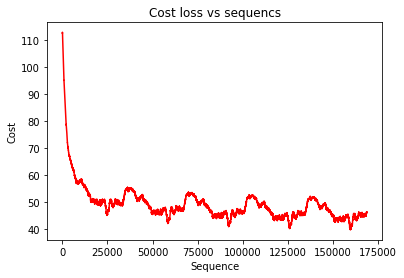

In [29]:
hiddenState = 100
eta = 0.1
seqLength = 25

# DEBUGGING SETTINGS
np.set_printoptions(precision=10)
np.random.seed(5)

rnn = RecurrentNeuralNetwork(numberOfClasses, numberOfClasses, hiddenState, seqLength) 
training = TrainingLoop(rnn, eta)
training.train(rnn.sequenceLength, epochs=5)

import matplotlib.pyplot as plt

plt.title('Cost loss vs sequencs')
plt.xlabel('Sequence')
plt.ylabel('Cost')
plt.plot(training.smooth_loss, 'r')
plt.show()


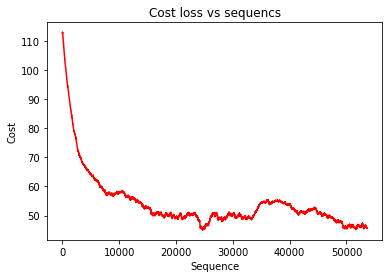

In [14]:
import matplotlib.pyplot as plt
plt.title('Cost loss vs sequencs')
plt.xlabel('Sequence')
plt.ylabel('Cost')
plt.plot(training.smooth_loss, 'r')
plt.show()

In [30]:
#100, 150, 200, 500 and 1000

training.createText(stringLength = 100, useBest = True)

training.createText(stringLength = 150, useBest = True)

training.createText(stringLength = 200, useBest = True)

training.createText(stringLength = 500, useBest = True)

training.createText(stringLength = 1000, useBest = True)

Printing best results from iteration:159742 with loss:39.6973771272
                           |||ATALDQZsIj   N     |||Rut peoun has liop un, the wilu! BL is an witisi
Printing best results from iteration:159742 with loss:39.6973771272
           |||We gustione Wirnsiobeday Trump I mubh wanguenour trayy! Thimilillen @gxouM_Thave that be meal Obimeving theAcone @AnTYE YAbeN.  -  - mig
Printing best results from iteration:159742 with loss:39.6973771272
      |||EHINKAZs THKU!BIA wasad tom ers gon NThuSchoriTruml! Trorkeg @Kr8T -tal so coVis Clonith wath and reat wing so job ruppwon, ited Greed tas. Iheis fillizen neight, Pinereght Crosanimere, hnok 
Printing best results from iteration:159742 with loss:39.6973771272
                                                                                 |||"@ALEOU! "             |||Je geded fred realdTrumpsuc. Sonde susted!  |||The cankibear son, the  forderine. |||"@groum #Dok_Joroningon mory #InA nignations.|||"@ratnows deVefor thin tes reap 